<a href="https://colab.research.google.com/github/adambueno/fraudDetection/blob/main/fraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

Adam Bueno's Fraud Detection data science research project!

Final Question: To what extent can we predict fraud based on known factors?

# Importing all the modules

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind

from sklearn import datasets, model_selection, metrics
from sklearn.feature_selection import SelectKBest

from imblearn.under_sampling import RandomUnderSampler

K Nearest Neighbors import

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Import and read csv

In [ ]:
fraud_df = pd.read_csv('/content/drive/MyDrive/fraudDetection/synthetic_fraud_dataset.csv')

In [ ]:
print(fraud_df.head(10))
fraud_df.columns
fraud_df.shape #50000 by 21
fraud_df.info() # no nulls
fraud_df.describe()

  Transaction_ID    User_ID  Transaction_Amount Transaction_Type  \
0      TXN_33553  USER_1834               39.79              POS   
1       TXN_9427  USER_7875                1.19    Bank Transfer   
2        TXN_199  USER_2734               28.96           Online   
3      TXN_12447  USER_2617              254.32   ATM Withdrawal   
4      TXN_39489  USER_2014               31.28              POS   
5      TXN_42724  USER_6852              168.55           Online   
6      TXN_10822  USER_5052                3.79              POS   
7      TXN_49498  USER_4660                7.08   ATM Withdrawal   
8       TXN_4144  USER_1584               34.25   ATM Withdrawal   
9      TXN_36958  USER_9498               16.24              POS   

             Timestamp  Account_Balance Device_Type  Location  \
0  2023-08-14 19:30:00         93213.17      Laptop    Sydney   
1  2023-06-07 04:01:00         75725.25      Mobile  New York   
2  2023-06-20 15:25:00          1588.96      Tablet    M

,Transaction_Amount,Account_Balance,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Age,Transaction_Distance,Risk_Score,Is_Weekend,Fraud_Label
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,99.411012,50294.065981,0.05020,0.098400,7.485240,255.271924,2.003540,119.999940,2499.164155,0.501556,0.299640,0.321340
std,98.687292,28760.458557,0.21836,0.297858,4.039637,141.382279,1.414273,68.985817,1442.013834,0.287774,0.458105,0.466996
min,0.000000,500.480000,0.00000,0.000000,1.000000,10.000000,0.000000,1.000000,0.250000,0.000100,0.000000,0.000000
25%,28.677500,25355.995000,0.00000,0.000000,4.000000,132.087500,1.000000,60.000000,1256.497500,0.254000,0.000000,0.000000
50%,69.660000,50384.430000,0.00000,0.000000,7.000000,256.085000,2.000000,120.000000,2490.785000,0.502250,0.000000,0.000000
75%,138.852500,75115.135000,0.00000,0.000000,11.000000,378.032500,3.000000,180.000000,3746.395000,0.749525,1.000000,1.000000
max,1174.140000,99998.310000,1.00000,1.000000,14.000000,500.000000,4.000000,239.000000,4999.930000,1.000000,1.000000,1.000000


Rename columns

In [ ]:
new_column_names = {
    'Transaction_ID' : 'Transaction ID',
    'User_ID': 'User ID',
    'Transaction_Amount': 'Transaction Amount',
    'Transaction_Type': 'Transaction Type',
    'Timestamp': 'Timestamp',
    'Account_Balance': 'Account Balance',
    'Device_Type': 'Device Type',
    'Location': 'Location',
    'Merchant_Category': 'Merchant Category',
    'IP_Address_Flag': 'IP Address Flag',
    'Previous_Fraudulent_Activity': 'Previous Fraudulent Activity',
    'Daily_Transaction_Count': 'Daily Transaction Count',
    'Avg_Transaction_Amount_7d': 'Avg Transaction Amount 7d',
    'Failed_Transaction_Count_7d': 'Failed Transaction Count 7d',
    'Card_Type': 'Card Type',
    'Card_Age': 'Card Age',
    'Transaction_Distance': 'Transaction Distance',
    'Authentication_Method': 'Authentication Method',
    'Risk_Score': 'Risk Score',
    'Is_Weekend': 'Is Weekend',
    'Fraud_Label': 'Fraud Label'
}
fraud_df.rename(columns=new_column_names, inplace=True)
print(fraud_df.columns)

Index(['Transaction ID', 'User ID', 'Transaction Amount', 'Transaction Type',
       'Timestamp', 'Account Balance', 'Device Type', 'Location',
       'Merchant Category', 'IP Address Flag', 'Previous Fraudulent Activity',
       'Daily Transaction Count', 'Avg Transaction Amount 7d',
       'Failed Transaction Count 7d', 'Card Type', 'Card Age',
       'Transaction Distance', 'Authentication Method', 'Risk Score',
       'Is Weekend', 'Fraud Label'],
      dtype='object')


# Exploratory Data Analysis

In [ ]:
fraud_df['Timestamp'].value_counts()

,count
Timestamp,
2023-06-04 06:35:00,4
2023-05-30 08:46:00,3
2023-04-28 05:47:00,3
2023-03-19 10:11:00,3
2023-01-07 01:41:00,3
...,...
2023-12-01 08:52:00,1
2023-08-10 01:56:00,1
2023-10-22 04:35:00,1


How much fraud is there? (Unbalanced dataset)

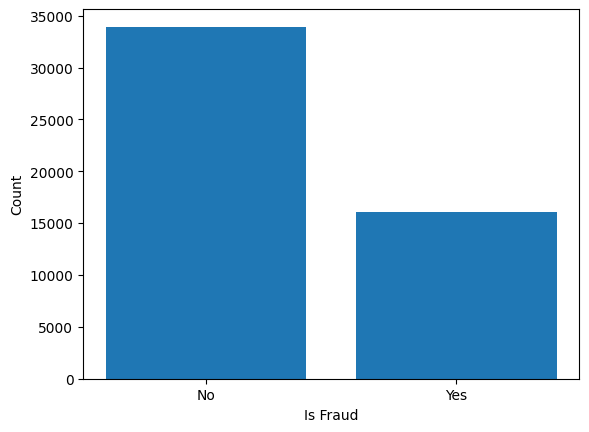

In [ ]:
fraudulent_counts = len(fraud_df[fraud_df['Fraud Label'] == 1].value_counts())
no_fraud_counts = len(fraud_df[fraud_df['Fraud Label'] == 0].value_counts())
plt.bar([0,1], [no_fraud_counts, fraudulent_counts])
plt.xticks([0,1], ['No', 'Yes'])
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

Device type vs fraud count (not helpful)

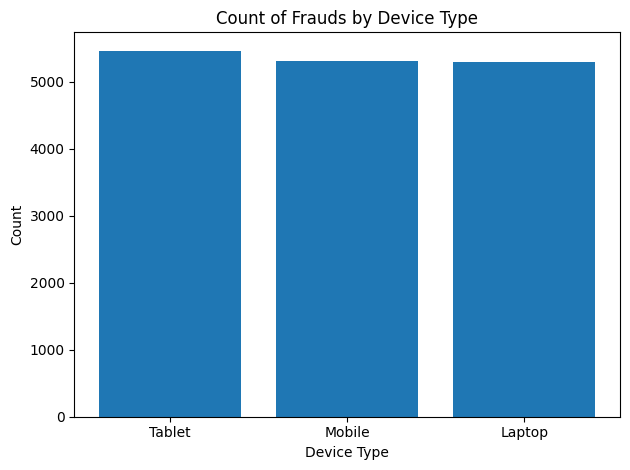

In [ ]:
fraudulent_device_counts = fraud_df[fraud_df['Fraud Label'] == 1]['Device Type'].value_counts()
plt.bar(fraudulent_device_counts.index, fraudulent_device_counts.values)
plt.xlabel('Device Type')
plt.ylabel('Count')
plt.title('Count of Frauds by Device Type')
plt.tight_layout()
plt.show()

Is weekend and fraud label == 1

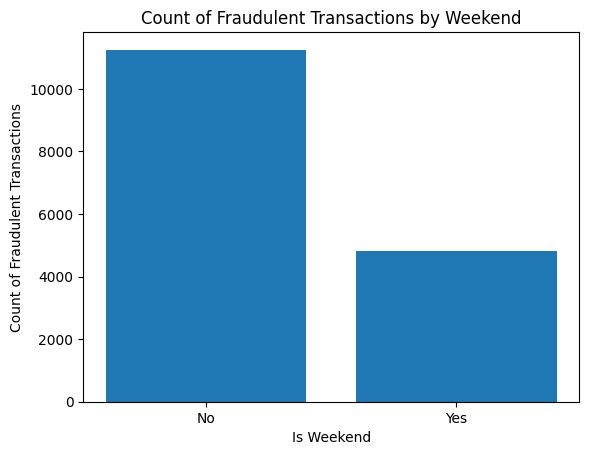

In [ ]:
fraudulent_weekend_counts = fraud_df[fraud_df['Fraud Label'] == 1]['Is Weekend'].value_counts()

plt.bar(fraudulent_weekend_counts.index, fraudulent_weekend_counts.values)
plt.xlabel('Is Weekend')
plt.ylabel('Count of Fraudulent Transactions')
plt.title('Count of Fraudulent Transactions by Weekend')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

## The two next graphs are the ones I would like to showcase on my EDA

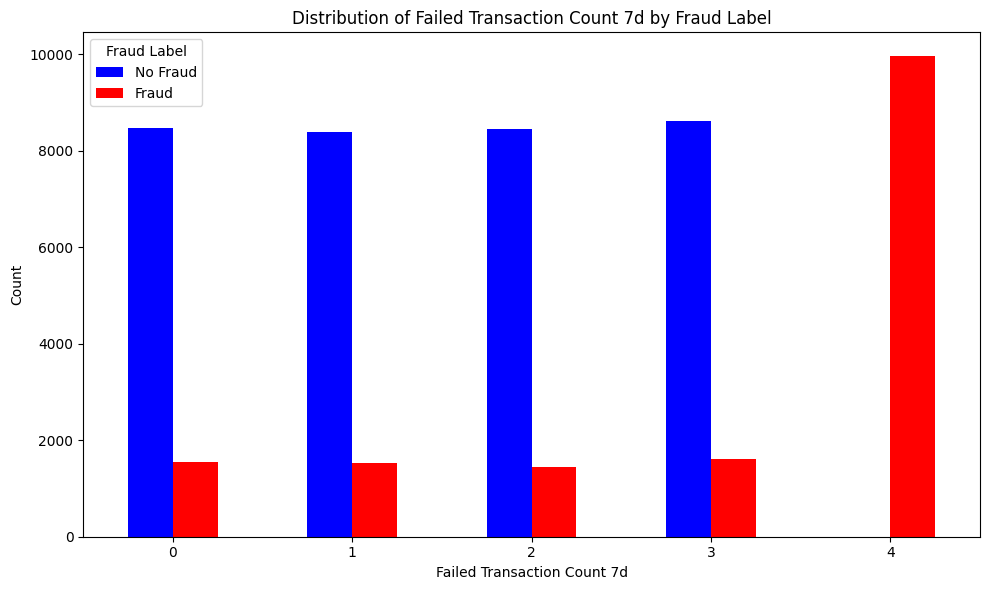

In [ ]:
fraudulent_counts = fraud_df.groupby('Failed Transaction Count 7d')['Fraud Label'].value_counts().unstack(fill_value=0)

fraudulent_counts.plot(kind='bar', figsize=(10, 6), color=['blue', 'red'])

plt.xlabel('Failed Transaction Count 7d')
plt.ylabel('Count')
plt.title('Distribution of Failed Transaction Count 7d by Fraud Label')
plt.xticks(rotation=0)
plt.legend(title='Fraud Label', labels=['No Fraud', 'Fraud'])
plt.tight_layout()
plt.show()

In [ ]:
fraud_df['Risk Score'].describe()

,Risk Score
count,50000.000000
mean,0.501556
std,0.287774
min,0.000100
25%,0.254000
50%,0.502250
75%,0.749525
max,1.000000


In [ ]:
fraud_df['Risk Category'] = 'unknown'

fraud_df['Risk Category'][fraud_df['Risk Score'] <= 0.2] = 1
fraud_df['Risk Category'][(fraud_df['Risk Score'] > 0.2) & (fraud_df['Risk Score'] <= 0.4)] = 2
fraud_df['Risk Category'][(fraud_df['Risk Score'] > 0.4) & (fraud_df['Risk Score'] <= 0.6)] = 3
fraud_df['Risk Category'][(fraud_df['Risk Score'] > 0.6) & (fraud_df['Risk Score'] <= 0.8)] = 4
fraud_df['Risk Category'][fraud_df['Risk Score'] > 0.8] = 5

0        5
1        1
2        5
3        4
4        2
        ..
49995    1
49996    2
49997    3
49998    4
49999    5
Name: Risk Category, Length: 50000, dtype: object
Risk Category
1    0.196548
2    0.201953
3    0.197782
4    0.201287
5    0.804866
Name: Fraud Label, dtype: float64


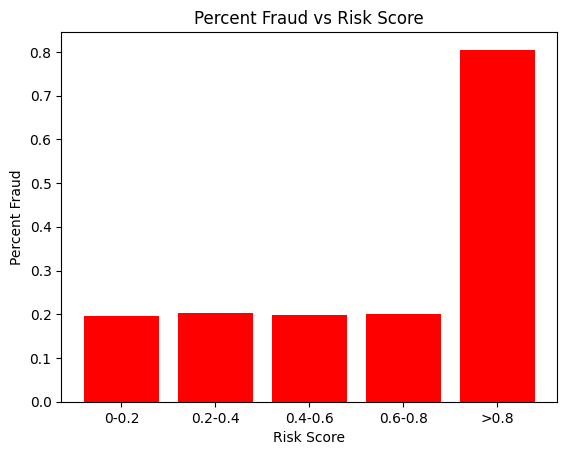

In [ ]:
print(fraud_df['Risk Category'])
grouped_data = fraud_df.groupby(fraud_df['Risk Category'])
fraud_frac = grouped_data['Fraud Label'].mean()
print(fraud_frac)

plt.bar(['0-0.2','0.2-0.4', '0.4-0.6','0.6-0.8','>0.8'], fraud_frac, color = ['r','r','r','r','r'])
plt.xlabel('Risk Score')
plt.ylabel('Percent Fraud')
plt.title('Percent Fraud vs Risk Score')
plt.show()

Drop Risk Category (no longer needed)

In [ ]:
fraud_df.drop('Risk Category', axis = 1)

,Transaction ID,User ID,Transaction Amount,Transaction Type,Timestamp,Account Balance,Device Type,Location,Merchant Category,IP Address Flag,...,Daily Transaction Count,Avg Transaction Amount 7d,Failed Transaction Count 7d,Card Type,Card Age,Transaction Distance,Authentication Method,Risk Score,Is Weekend,Fraud Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,TXN_11284,USER_4796,45.05,Online,2023-01-29 18:38:00,76960.11,Mobile,Tokyo,Clothing,0,...,2,389.00,3,Amex,98,1537.54,PIN,0.1493,1,0
49996,TXN_44732,USER_1171,126.15,POS,2023-05-09 08:55:00,28791.75,Mobile,Tokyo,Clothing,0,...,13,434.95,4,Visa,93,2555.72,Biometric,0.3653,0,1
49997,TXN_38158,USER_2510,72.02,Online,2023-01-30 19:32:00,29916.41,Laptop,Mumbai,Clothing,0,...,1,369.15,2,Visa,114,4686.59,Biometric,0.5195,0,0
49998,TXN_860,USER_2248,64.89,Bank Transfer,2023-03-09 19:47:00,67895.67,Mobile,Tokyo,Electronics,0,...,13,242.29,4,Discover,72,4886.92,Biometric,0.7063,0,1


## Find the best correlations (numerical)

In [ ]:
# Calculate the correlation matrix
correlation_matrix = fraud_df.corr(numeric_only=True)

# Get the correlations with 'Fraud Label'
fraud_correlation = correlation_matrix['Fraud Label'].sort_values(ascending=False)

# Display the correlations
print("Correlation with Fraud Label:")
print(fraud_correlation)

Correlation with Fraud Label:
Fraud Label                     1.000000
Failed Transaction Count 7d     0.509871
Risk Score                      0.385810
IP Address Flag                 0.003028
Transaction Amount              0.001901
Avg Transaction Amount 7d       0.000703
Is Weekend                      0.000064
Transaction Distance           -0.000116
Previous Fraudulent Activity   -0.000718
Card Age                       -0.003120
Account Balance                -0.003153
Daily Transaction Count        -0.007065
Name: Fraud Label, dtype: float64


Maybe there are values correlated with risk score?

In [ ]:
correlation_matrix = fraud_df.corr(numeric_only=True)

# Get the correlations with 'Fraud Label'
fraud_correlation = correlation_matrix['Risk Score'].sort_values(ascending=False)

# Display the correlations
print("Correlation with Risk Score:")
print(fraud_correlation)

Correlation with Risk Score:
Risk Score                      1.000000
Fraud Label                     0.385810
Transaction Amount              0.005606
Avg Transaction Amount 7d       0.004977
Failed Transaction Count 7d     0.000814
Card Age                       -0.001385
Transaction Distance           -0.001902
Previous Fraudulent Activity   -0.002815
IP Address Flag                -0.004064
Is Weekend                     -0.005236
Account Balance                -0.005262
Daily Transaction Count        -0.007572
Name: Risk Score, dtype: float64


What about values correlated with failed transaction count?

In [ ]:
correlation_matrix = fraud_df.corr(numeric_only=True)

# Get the correlations with 'Failed Transaction Count 7d'
fraud_correlation = correlation_matrix['Failed Transaction Count 7d'].sort_values(ascending=False)

# Display the correlations
print("Correlation with Failed Transaction Count 7d")
print(fraud_correlation)

Correlation with Fraud Label:
Failed Transaction Count 7d     1.000000
Fraud Label                     0.509871
IP Address Flag                 0.010370
Avg Transaction Amount 7d       0.006583
Transaction Amount              0.001247
Risk Score                      0.000814
Account Balance                -0.000186
Previous Fraudulent Activity   -0.000352
Is Weekend                     -0.003335
Card Age                       -0.004570
Transaction Distance           -0.006997
Daily Transaction Count        -0.007820
Name: Failed Transaction Count 7d, dtype: float64


What about IP Address Flag?

In [ ]:
'''
  IP Address Flag is not correlated with Fraud Label very much
'''



correlation_matrix = fraud_df.corr(numeric_only=True)

# Get the correlations with 'IP Address Flag'
fraud_correlation = correlation_matrix['IP Address Flag'].sort_values(ascending=False)

# Display the correlations
print("Correlation with IP Address Flag:")
print(fraud_correlation)

Correlation with IP Address Flag:
IP Address Flag                 1.000000
Failed Transaction Count 7d     0.010370
Is Weekend                      0.004979
Fraud Label                     0.003028
Daily Transaction Count         0.001815
Account Balance                -0.001210
Transaction Amount             -0.001620
Card Age                       -0.003143
Transaction Distance           -0.003941
Risk Score                     -0.004064
Avg Transaction Amount 7d      -0.004845
Previous Fraudulent Activity   -0.008298
Name: IP Address Flag, dtype: float64


## Finding correlations (categorical)

How about exploring Location vs fraud

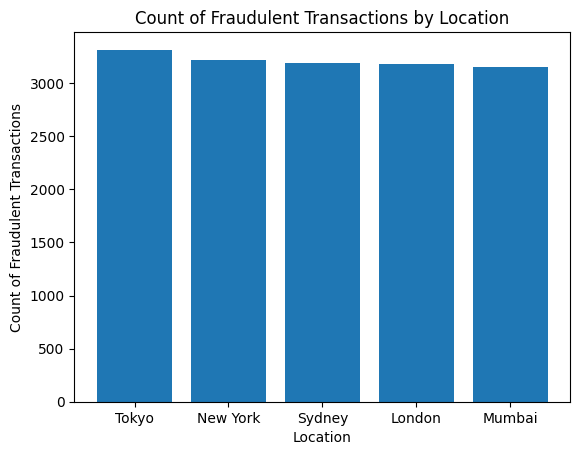

In [ ]:
fraud_df['Location'].value_counts()

fraudulent_location_counts = fraud_df[fraud_df['Fraud Label'] == 1]['Location'].value_counts()

plt.bar(fraudulent_location_counts.index, fraudulent_location_counts.values)
plt.xlabel('Location')
plt.ylabel('Count of Fraudulent Transactions')
plt.title('Count of Fraudulent Transactions by Location')
plt.show()

What type of card gets the most fraud?

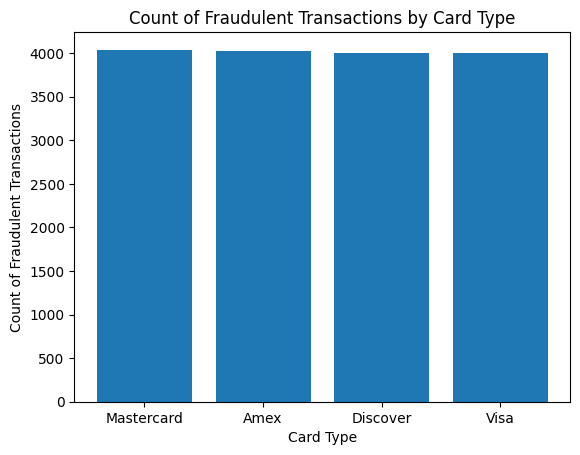

In [ ]:
fraudulent_card_counts = fraud_df[fraud_df['Fraud Label'] == 1]['Card Type'].value_counts()

plt.bar(fraudulent_card_counts.index, fraudulent_card_counts.values)
plt.xlabel('Card Type')
plt.ylabel('Count of Fraudulent Transactions')
plt.title('Count of Fraudulent Transactions by Card Type')
plt.show()

Transaction type and fraud

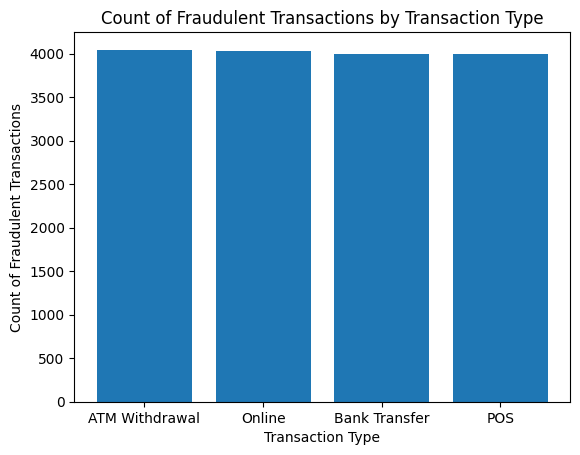

Transaction Type
POS               12549
Online            12546
ATM Withdrawal    12453
Bank Transfer     12452
Name: count, dtype: int64


In [ ]:
fraudulent_trans_counts = fraud_df[fraud_df['Fraud Label'] == 1]['Transaction Type'].value_counts()

plt.bar(fraudulent_trans_counts.index, fraudulent_trans_counts.values)
plt.xlabel('Transaction Type')
plt.ylabel('Count of Fraudulent Transactions')
plt.title('Count of Fraudulent Transactions by Transaction Type')
plt.show()
print(fraud_df['Transaction Type'].value_counts())

Authentication method and fraud

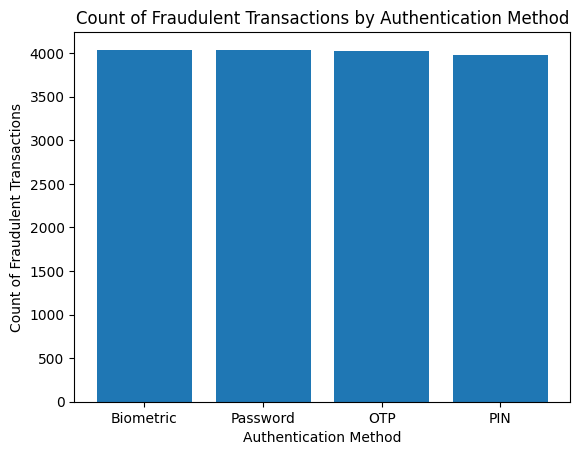

Authentication Method
Biometric    12591
PIN          12586
Password     12457
OTP          12366
Name: count, dtype: int64


In [ ]:
fraudulent_auth_counts = fraud_df[fraud_df['Fraud Label'] == 1]['Authentication Method'].value_counts()

plt.bar(fraudulent_auth_counts.index, fraudulent_auth_counts.values)
plt.xlabel('Authentication Method')
plt.ylabel('Count of Fraudulent Transactions')
plt.title('Count of Fraudulent Transactions by Authentication Method')
plt.show()
print(fraud_df['Authentication Method'].value_counts())

Merchant Category and fraud

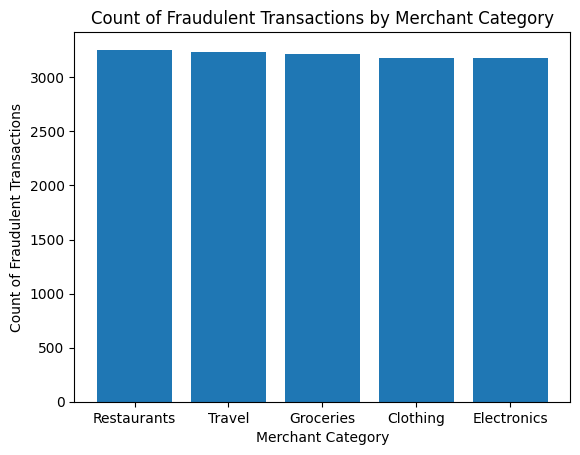

In [ ]:
fraudulent_merch_counts = fraud_df[fraud_df['Fraud Label'] == 1]['Merchant Category'].value_counts()

plt.bar(fraudulent_merch_counts.index, fraudulent_merch_counts.values)
plt.xlabel('Merchant Category')
plt.ylabel('Count of Fraudulent Transactions')
plt.title('Count of Fraudulent Transactions by Merchant Category')
plt.show()

Here is proof that timestamps will not be helpful

In [ ]:
len(fraud_df['Timestamp'].unique())

47724

In [ ]:
print(fraud_df.dtypes)
print(fraud_df['Transaction Type'].unique())
print(fraud_df['Device Type'].unique())
print(fraud_df['Location'].unique())
print(fraud_df['Merchant Category'].unique())
print(fraud_df['Card Type'].unique())
print(fraud_df['Authentication Method'].unique())

Transaction ID                   object
User ID                          object
Transaction Amount              float64
Transaction Type                 object
Timestamp                        object
Account Balance                 float64
Device Type                      object
Location                         object
Merchant Category                object
IP Address Flag                   int64
Previous Fraudulent Activity      int64
Daily Transaction Count           int64
Avg Transaction Amount 7d       float64
Failed Transaction Count 7d       int64
Card Type                        object
Card Age                          int64
Transaction Distance            float64
Authentication Method            object
Risk Score                      float64
Is Weekend                        int64
Fraud Label                       int64
Risk Category                    object
dtype: object
['POS' 'Bank Transfer' 'Online' 'ATM Withdrawal']
['Laptop' 'Mobile' 'Tablet']
['Sydney' 'New York' 'Mumba

In [ ]:
categorical_columns = ['Transaction Type', 'Device Type', 'Location', 'Merchant Category', 'Card Type', 'Authentication Method']
fraud_encoded = pd.get_dummies(fraud_df, columns=categorical_columns, drop_first=True)
print(fraud_encoded.head())

  Transaction ID    User ID  Transaction Amount            Timestamp  \
0      TXN_33553  USER_1834               39.79  2023-08-14 19:30:00   
1       TXN_9427  USER_7875                1.19  2023-06-07 04:01:00   
2        TXN_199  USER_2734               28.96  2023-06-20 15:25:00   
3      TXN_12447  USER_2617              254.32  2023-12-07 00:31:00   
4      TXN_39489  USER_2014               31.28  2023-11-11 23:44:00   

   Account Balance  IP Address Flag  Previous Fraudulent Activity  \
0         93213.17                0                             0   
1         75725.25                0                             0   
2          1588.96                0                             0   
3         76807.20                0                             0   
4         92354.66                0                             1   

   Daily Transaction Count  Avg Transaction Amount 7d  \
0                        7                     437.63   
1                       13            

In [ ]:
correlation_matrix_encoded = fraud_encoded.corr(numeric_only=True)
encoded_fraud_correlation = correlation_matrix_encoded['Fraud Label'].sort_values(ascending=False)
print("Correlation with Fraud Label (including encoded variables):")
print(encoded_fraud_correlation)

Correlation with Fraud Label (including encoded variables):
Fraud Label                       1.000000
Failed Transaction Count 7d       0.509871
Risk Score                        0.385810
Device Type_Tablet                0.006552
Merchant Category_Restaurants     0.005285
Authentication Method_OTP         0.004696
Card Type_Discover                0.004424
Location_New York                 0.003750
Location_Tokyo                    0.003693
IP Address Flag                   0.003028
Authentication Method_Password    0.002680
Transaction Amount                0.001901
Merchant Category_Travel          0.001796
Avg Transaction Amount 7d         0.000703
Is Weekend                        0.000064
Location_Sydney                   0.000056
Transaction Type_Online          -0.000053
Transaction Distance             -0.000116
Merchant Category_Groceries      -0.000268
Transaction Type_Bank Transfer   -0.000626
Previous Fraudulent Activity     -0.000718
Merchant Category_Electronics    -0.0

In [ ]:
print(encoded_fraud_correlation)

Fraud Label                       1.000000
Failed Transaction Count 7d       0.509871
Risk Score                        0.385810
Device Type_Tablet                0.006552
Merchant Category_Restaurants     0.005285
Authentication Method_OTP         0.004696
Card Type_Discover                0.004424
Location_New York                 0.003750
Location_Tokyo                    0.003693
IP Address Flag                   0.003028
Authentication Method_Password    0.002680
Transaction Amount                0.001901
Merchant Category_Travel          0.001796
Avg Transaction Amount 7d         0.000703
Is Weekend                        0.000064
Location_Sydney                   0.000056
Transaction Type_Online          -0.000053
Transaction Distance             -0.000116
Merchant Category_Groceries      -0.000268
Transaction Type_Bank Transfer   -0.000626
Previous Fraudulent Activity     -0.000718
Merchant Category_Electronics    -0.002207
Card Age                         -0.003120
Account Bal

## Conclusions from EDA:

Numerical: The best indicators for calculating fraud are Failed Transaction Count 7d and Risk Score.

Categorical: Device Type Tablet has the largest correlation with fraud, however this correlation is quite weak.

The best model to use is **k nearest neighbors** with Failed Transaction Count 7d and Risk Score. (given that Fraud Label is binary)

# T test

## Failed Transaction Count 7d T test

Null hypothesis: Fraudulent transactions have no association with the number of failed transactions in the past 7 days.

Alternative hypothesis: An increase in failed transactions in the past 7 days is associated with an increase in fraudulent transactions.

Make subsets

In [ ]:
non_fraud_trans = fraud_df[fraud_df['Fraud Label'] == 0]['Failed Transaction Count 7d']
fraud_trans = fraud_df[fraud_df['Fraud Label'] == 1]['Failed Transaction Count 7d']

Run T test

In [ ]:
t_stat, p_val = ttest_ind(non_fraud_trans, fraud_trans)

Interpret results

In [ ]:
print(t_stat)
print(p_val)

-132.52926343063783
0.0


The p value displayed, 0.0 (most likely due to the computer rounding), shows that the probability of the event occuring randomly is 0%. In other words, we reject the null hypothesis!

## Risk Score T test

Null hypothesis: Fraudulent transactions have no association with the risk score with the account.

Alternative hypothesis: An increase in risk score is associated with an increase in fradulent transactions.

Make subsets

In [ ]:
non_fraud_risk = fraud_df[fraud_df['Fraud Label'] == 0]['Risk Score']
fraud_risk = fraud_df[fraud_df['Fraud Label'] == 1]['Risk Score']

Run T test

In [ ]:
t_stat, p_val = ttest_ind(non_fraud_risk, fraud_risk)

Interpret results

In [ ]:
print(t_stat)
print(p_val)

-93.50752106232488
0.0


The p value displayed, 0.0 (most likely due to the computer rounding), shows that the probability of the event occuring randomly is 0%. In other words, we reject the null hypothesis!

# K Nearest Neighbors with all features
As previously established, The best two features for detecting Fraud (Fraud Label) are 'Failed Transaction Count 7d' and 'Risk Score'. Let's implement a KNN model to try and predict fraud using these two best features.

Isolate features

In [ ]:
features = fraud_df.drop('Fraud Label', axis = 1)
features = features.select_dtypes(exclude=['object'])
label = fraud_df['Fraud Label']

Split the data

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, label, test_size = 0.2, random_state = 42)

Start KNN model

In [ ]:
model = KNeighborsClassifier(n_neighbors = 5)

Fit the data and make predictions

In [ ]:
model.fit(X_train, y_train)
pred = model.predict(X_test)

## Confusion Matrix, Accuracy score, and F1 Score

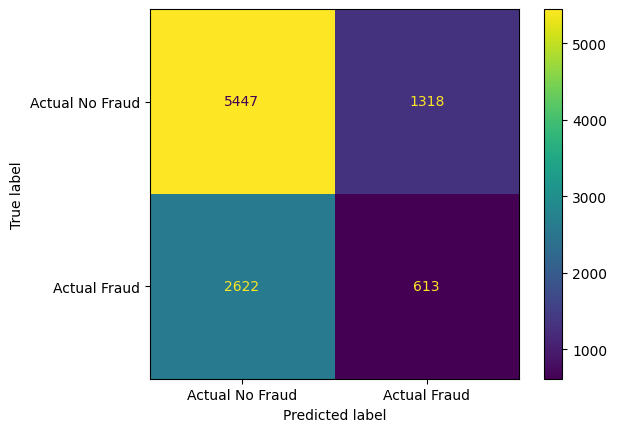

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels=['Actual No Fraud', 'Actual Fraud'])

In [ ]:
print("Accuracy Score: ", metrics.accuracy_score(y_test, pred))

Accuracy Score:  0.606


In [ ]:
f1 = metrics.f1_score(y_test, pred)

print(f"F1 Score: {f1}")

F1 Score: 0.2373209446380178


## K Fold Cross Validation

In [ ]:
knn_5 = KNeighborsClassifier(n_neighbors = 5)

scores_5 = model_selection.cross_val_score(knn_5, X_train, y_train, cv = 10)
print("10-Folds CV Scores: " + str(scores_5.mean()) + " +/- " + str(scores_5.std()))

10-Folds CV Scores: 0.6152 +/- 0.010046641229784211


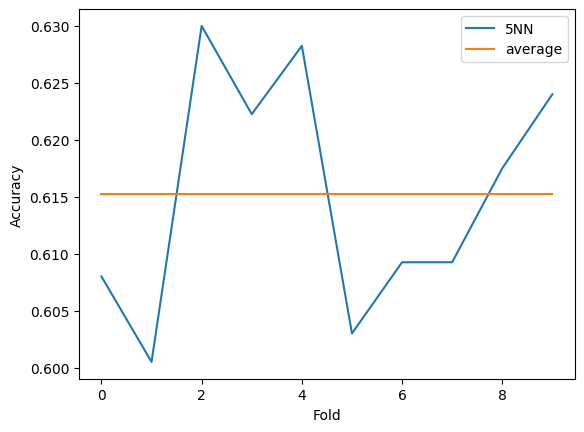

In [ ]:
plt.plot(scores_5, label = '5NN')
plt.plot([scores_5.mean() for i in range(10)], label = 'average')

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# K Nearest Neighbors with best features

Using all the features clearly leads to low accuracy, so let us attempt the same machine learning model but with only the two best features, 'Failed Transaction Count 7d' and 'Risk Score'.

Isolate the features

In [ ]:
features = fraud_df[['Failed Transaction Count 7d', 'Risk Score']]
label = fraud_df['Fraud Label']

Split the data

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, label, test_size = 0.2, random_state = 42)

Start KNN model

In [ ]:
model = KNeighborsClassifier(n_neighbors = 5)

Fit the data and make predictions

In [ ]:
model.fit(X_train, y_train)
pred = model.predict(X_test)

## Decision Boundary

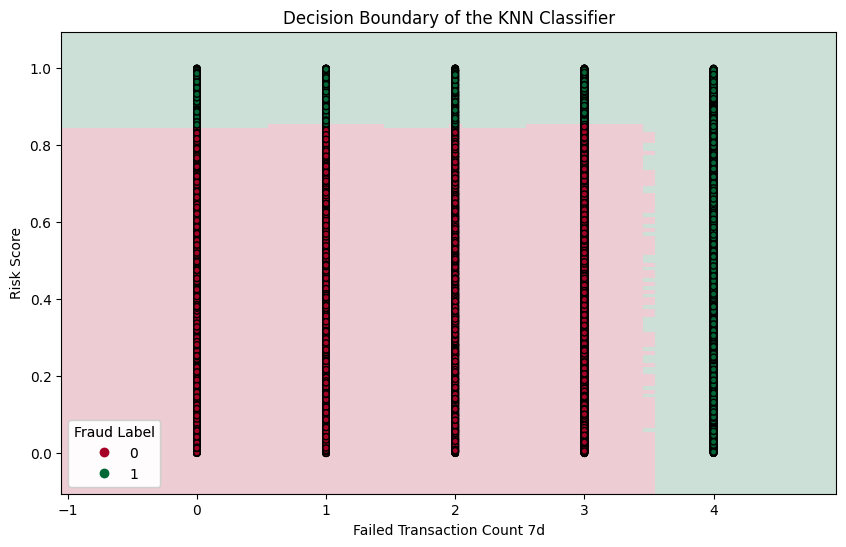

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

x_min, x_max = X_train['Failed Transaction Count 7d'].min() - 1, X_train['Failed Transaction Count 7d'].max() + 1
y_min, y_max = X_train['Risk Score'].min() - 0.1, X_train['Risk Score'].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.01))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.pcolormesh(xx, yy, Z, alpha=0.2, cmap=plt.cm.RdYlGn)

scatter = ax.scatter(X_train['Failed Transaction Count 7d'], X_train['Risk Score'], c=y_train, edgecolor='k', s=20, cmap=plt.cm.RdYlGn)

ax.set_title("Decision Boundary of the KNN Classifier")
ax.set_xlabel("Failed Transaction Count 7d")
ax.set_ylabel("Risk Score")

legend = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Fraud Label")
ax.add_artist(legend)


plt.show()

## Confusion Matrix, accuracy score, and F1 score

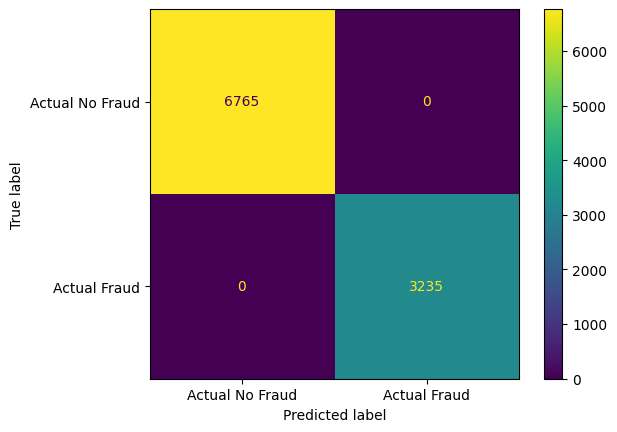

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels=['Actual No Fraud', 'Actual Fraud'])

In [ ]:
print("Accuracy Score: ", metrics.accuracy_score(y_test, pred))

Accuracy Score:  1.0


In [ ]:
f1 = metrics.f1_score(y_test, pred)

print(f"F1 Score: {f1}")

F1 Score: 1.0


## K fold cross validation

In [ ]:
knn_5 = KNeighborsClassifier(n_neighbors = 5)

scores_5 = model_selection.cross_val_score(knn_5, X_train, y_train, cv = 10)
print("10-Folds CV Scores: " + str(scores_5.mean()) + " +/- " + str(scores_5.std()))

10-Folds CV Scores: 0.99975 +/- 0.0002499999999999947


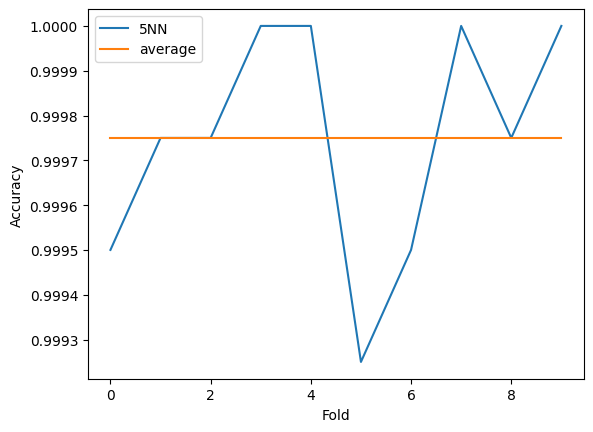

In [ ]:
plt.plot(scores_5, label = '5NN')
plt.plot([scores_5.mean() for i in range(10)], label = 'average')

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# KNN without best features

I would like to see the impact of the "best" columns (according to the correlations method) on the KNN model.

Features WITHOUT best features. Label is kept the same.

In [ ]:
features = fraud_encoded.drop(['Failed Transaction Count 7d','Risk Score'], axis = 1)
features = features.select_dtypes(exclude=['object']) #we cannot coerce strings to be floats sadly (so no more transaction and user ID)
label = fraud_encoded['Fraud Label']
features.head()

,Transaction Amount,Account Balance,IP Address Flag,Previous Fraudulent Activity,Daily Transaction Count,Avg Transaction Amount 7d,Card Age,Transaction Distance,Is Weekend,Fraud Label,...,Merchant Category_Electronics,Merchant Category_Groceries,Merchant Category_Restaurants,Merchant Category_Travel,Card Type_Discover,Card Type_Mastercard,Card Type_Visa,Authentication Method_OTP,Authentication Method_PIN,Authentication Method_Password
0,39.79,93213.17,0,0,7,437.63,65,883.17,0,0,...,False,False,False,True,False,False,False,False,False,False
1,1.19,75725.25,0,0,13,478.76,186,2203.36,0,1,...,False,False,False,False,False,True,False,False,False,True
2,28.96,1588.96,0,0,14,50.01,226,1909.29,0,1,...,False,False,True,False,False,False,True,False,False,False
3,254.32,76807.20,0,0,8,182.48,76,1311.86,0,1,...,False,False,False,False,False,False,True,True,False,False
4,31.28,92354.66,0,1,14,328.69,140,966.98,1,1,...,True,False,False,False,False,True,False,False,False,True


Split the data

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, label, test_size = 0.2, random_state = 42)

Start KNN model

In [ ]:
model = KNeighborsClassifier(n_neighbors = 5)

Fit model and make predictions

In [ ]:
model.fit(X_train, y_train)
pred = model.predict(X_test)

Create a visualization

Decision boundaries are impossible without creating 29 dimensional spaces.


## Confusion matrix, Accuracy score, and F1 score

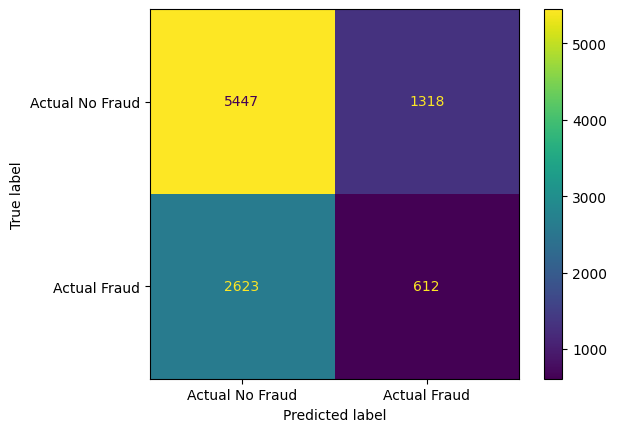

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels=['Actual No Fraud', 'Actual Fraud'])

In [ ]:
print("Accuracy Score: ", metrics.accuracy_score(y_test, pred))

Accuracy Score:  0.6059


In [ ]:
f1 = metrics.f1_score(y_test, pred)

print(f"F1 Score: {f1}")

F1 Score: 0.23697967086156824


## K fold cross validation

In [ ]:
knn_5 = KNeighborsClassifier(n_neighbors = 5)

scores_5 = model_selection.cross_val_score(knn_5, X_train, y_train, cv = 10)
print("10-Folds CV Scores: " + str(scores_5.mean()) + " +/- " + str(scores_5.std()))

10-Folds CV Scores: 0.6152 +/- 0.010046641229784211


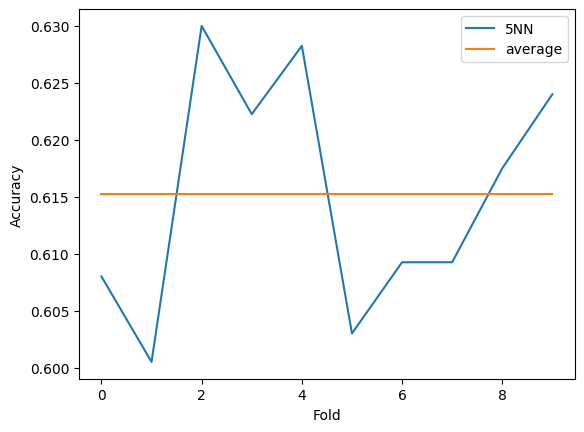

In [ ]:
plt.plot(scores_5, label = '5NN')
plt.plot([scores_5.mean() for i in range(10)], label = 'average')

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Conclusion from KNN
Using the two best features, the machine learning model was able to make predictions about this synthetic dataset that were 100% correct according to the Confusion Matrix, accuracy score, and F1 score.

# Undersampling to deal with imbalanced data - all features

In [ ]:
features = fraud_df.drop('Fraud Label', axis = 1)
features = features.select_dtypes(exclude=['object'])
label = fraud_df['Fraud Label']

<Axes: ylabel='count'>

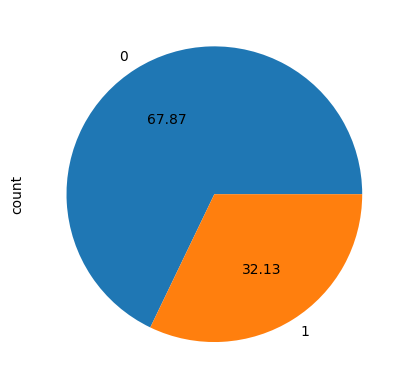

In [ ]:
label.value_counts().plot.pie(autopct='%.2f')

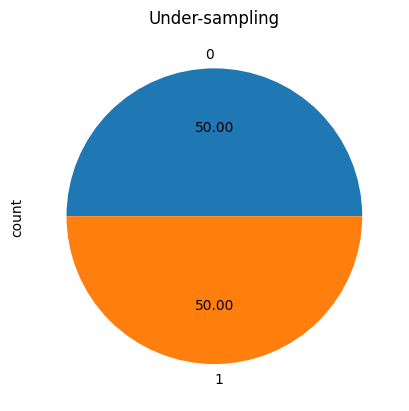

In [ ]:


#rus = RandomUnderSampler(sampling_strategy=1) # Numerical value
rus = RandomUnderSampler(sampling_strategy="not minority") # String
X_res, y_res = rus.fit_resample(features, label)

ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")


## KNN with undersampling

Now that we have effectively shrunk the data, let's try making a KNN model again.

Note: Our features and label for this are

```
X_res and y_res
```
accordingly.


Split the data:

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_res, y_res, test_size = 0.2, random_state = 42)

Start the model

In [ ]:
model = KNeighborsClassifier(n_neighbors = 5)

Fit the model and make predictions

In [ ]:
model.fit(X_train, y_train)
pred = model.predict(X_test)

### Confusion matrix, accuracy score, and f1 score

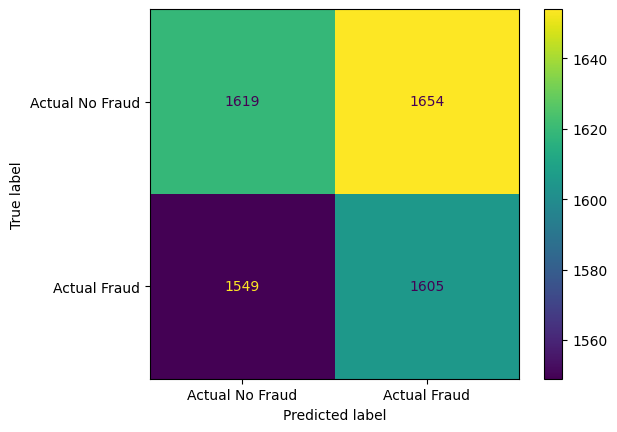

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels=['Actual No Fraud', 'Actual Fraud'])

In [ ]:
print("Accuracy Score: ", metrics.accuracy_score(y_test, pred))

Accuracy Score:  0.5016337326902132


In [ ]:
f1 = metrics.f1_score(y_test, pred)

print(f"F1 Score: {f1}")

F1 Score: 0.5005457664119757


### K fold cross validation

In [ ]:
knn_5 = KNeighborsClassifier(n_neighbors = 5)

scores_5 = model_selection.cross_val_score(knn_5, X_train, y_train, cv = 10)
print("10-Folds CV Scores: " + str(scores_5.mean()) + " +/- " + str(scores_5.std()))

10-Folds CV Scores: 0.498969878031985 +/- 0.009730548018400257


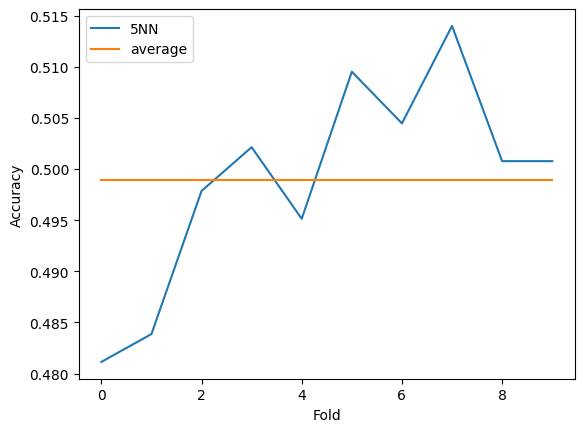

In [ ]:
plt.plot(scores_5, label = '5NN')
plt.plot([scores_5.mean() for i in range(10)], label = 'average')

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Undersampling to deal with imbalanced data - best features

In [ ]:
features = fraud_df[['Failed Transaction Count 7d', 'Risk Score']]
label = fraud_df['Fraud Label']

<Axes: ylabel='count'>

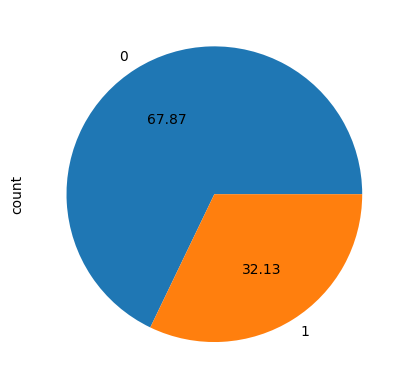

In [ ]:
label.value_counts().plot.pie(autopct='%.2f')

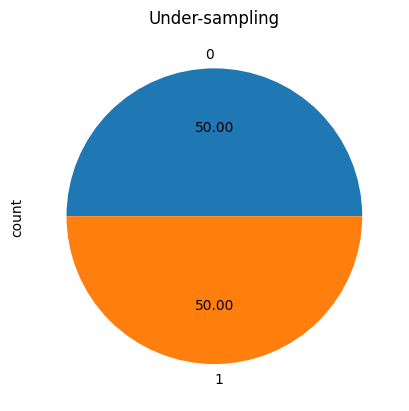

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

#rus = RandomUnderSampler(sampling_strategy=1) # Numerical value
rus = RandomUnderSampler(sampling_strategy="not minority") # String
X_res, y_res = rus.fit_resample(features, label)

ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

## KNN with undersampling

Split the data

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_res, y_res, test_size = 0.2, random_state = 42)

Start the model

In [ ]:
model = KNeighborsClassifier(n_neighbors = 5)

Fit the model and make predictions

In [ ]:
model.fit(X_train, y_train)
pred = model.predict(X_test)

Decision Boundary

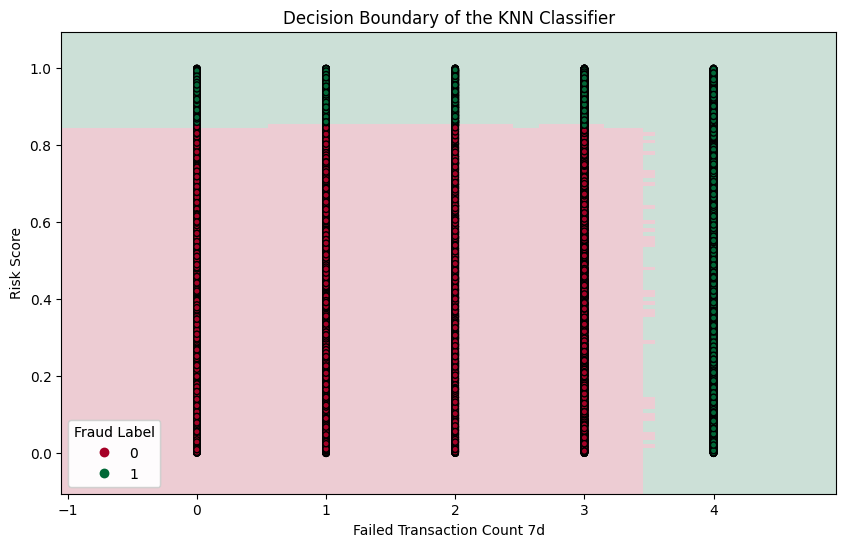

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

x_min, x_max = X_train['Failed Transaction Count 7d'].min() - 1, X_train['Failed Transaction Count 7d'].max() + 1
y_min, y_max = X_train['Risk Score'].min() - 0.1, X_train['Risk Score'].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.01))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.pcolormesh(xx, yy, Z, alpha=0.2, cmap=plt.cm.RdYlGn)

scatter = ax.scatter(X_train['Failed Transaction Count 7d'], X_train['Risk Score'], c=y_train, edgecolor='k', s=20, cmap=plt.cm.RdYlGn)

ax.set_title("Decision Boundary of the KNN Classifier")
ax.set_xlabel("Failed Transaction Count 7d")
ax.set_ylabel("Risk Score")

legend = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Fraud Label")
ax.add_artist(legend)


plt.show()

### Confusion matrix, accuracy score, and F1 Score

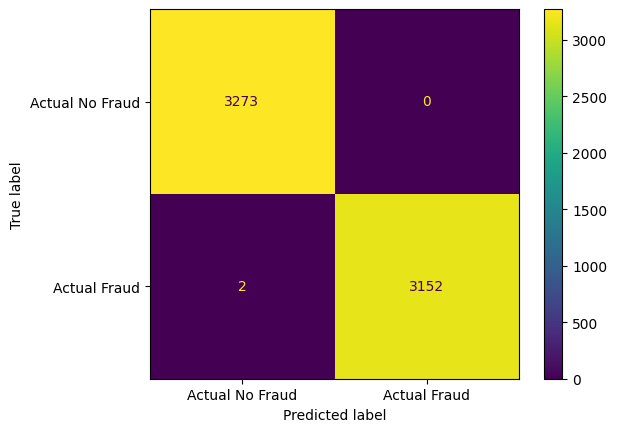

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels=['Actual No Fraud', 'Actual Fraud'])

In [ ]:
print("Accuracy Score: ", metrics.accuracy_score(y_test, pred))

Accuracy Score:  0.9996888128209118


In [ ]:
f1 = metrics.f1_score(y_test, pred)

print(f"F1 Score: {f1}")

F1 Score: 0.9996828417380272


### K fold cross validation

In [ ]:
knn_5 = KNeighborsClassifier(n_neighbors = 5)

scores_5 = model_selection.cross_val_score(knn_5, X_train, y_train, cv = 10)
print("10-Folds CV Scores: " + str(scores_5.mean()) + " +/- " + str(scores_5.std()))

10-Folds CV Scores: 0.9997277172654586 +/- 0.0003037883788837445


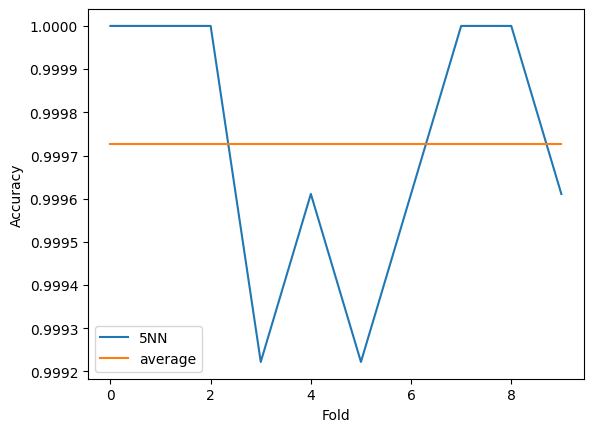

In [ ]:
plt.plot(scores_5, label = '5NN')
plt.plot([scores_5.mean() for i in range(10)], label = 'average')

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Conclusion from undersampling


Undersampling to deal with imbalanced data yielded the same results when it came to machine learning models. Due to the synthetic nature of the dataset, the machine learning model is able to predict fraud with very good accuracy.